In [5]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

In [15]:
from scipy.sparse import load_npz

import numpy as np
import csv
import os


def _load_csv(path):
    # A helper function to load the csv file.
    if not os.path.exists(path):
        raise Exception("The specified path {} does not exist.".format(path))
    # Initialize the data.
    data = {
        "user_id": [],
        "question_id": [],
        "is_correct": []
    }
    # Iterate over the row to fill in the data.
    with open(path, "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            try:
                data["question_id"].append(int(row[0]))
                data["user_id"].append(int(row[1]))
                data["is_correct"].append(int(row[2]))
            except ValueError:
                # Pass first row.
                pass
            except IndexError:
                # is_correct might not be available.
                pass
    return data


def load_train_sparse(root_dir="/data"):
    """ Load the training data as a spare matrix representation.

    :param root_dir: str
    :return: 2D sparse matrix
    """
    path = os.path.join(root_dir, "train_sparse.npz")
    if not os.path.exists(path):
        raise Exception("The specified path {} "
                        "does not exist.".format(os.path.abspath(path)))
    matrix = load_npz(path)
    return matrix


def load_train_csv(root_dir="/data"):
    """ Load the training data as a dictionary.

    :param root_dir: str
    :return: A dictionary {user_id: list, question_id: list, is_correct: list}
        WHERE
        user_id: a list of user id.
        question_id: a list of question id.
        is_correct: a list of binary value indicating the correctness of
        (user_id, question_id) pair.
    """
    path = os.path.join(root_dir, "train_data.csv")
    return _load_csv(path)


def load_valid_csv(root_dir="/data"):
    """ Load the validation data as a dictionary.

    :param root_dir: str
    :return: A dictionary {user_id: list, question_id: list, is_correct: list}
        WHERE
        user_id: a list of user id.
        question_id: a list of question id.
        is_correct: a list of binary value indicating the correctness of
        (user_id, question_id) pair.
    """
    path = os.path.join(root_dir, "valid_data.csv")
    return _load_csv(path)


def load_public_test_csv(root_dir="/data"):
    """ Load the test data as a dictionary.

    :param root_dir: str
    :return: A dictionary {user_id: list, question_id: list, is_correct: list}
        WHERE
        user_id: a list of user id.
        question_id: a list of question id.
        is_correct: a list of binary value indicating the correctness of
        (user_id, question_id) pair.
    """
    path = os.path.join(root_dir, "test_data.csv")
    return _load_csv(path)


def load_private_test_csv(root_dir="/data"):
    """ Load the private test data as a dictionary.

    :param root_dir: str
    :return: A dictionary {user_id: list, question_id: list, is_correct: list}
        WHERE
        user_id: a list of user id.
        question_id: a list of question id.
        is_correct: an empty list.
    """
    path = os.path.join(root_dir, "private_test_data.csv")
    return _load_csv(path)


def save_private_test_csv(data, file_name="private_test_result.csv"):
    """ Save the private test data as a csv file.

    This should be your submission file to Kaggle.
    :param data: A dictionary {user_id: list, question_id: list, is_correct: list}
        WHERE
        user_id: a list of user id.
        question_id: a list of question id.
        is_correct: a list of binary value indicating the correctness of
        (user_id, question_id) pair.
    :param file_name: str
    :return: None
    """
    if not isinstance(data, dict):
        raise Exception("Data must be a dictionary.")
    cur_id = 1
    valid_id = ["0", "1"]
    with open(file_name, "w") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["id", "is_correct"])
        for i in range(len(data["user_id"])):
            if str(int(data["is_correct"][i])) not in valid_id:
                raise Exception("Your data['is_correct'] is not in a valid format.")
            writer.writerow([str(cur_id), str(int(data["is_correct"][i]))])
            cur_id += 1
    return


def evaluate(data, predictions, threshold=0.5):
    """ Return the accuracy of the predictions given the data.

    :param data: A dictionary {user_id: list, question_id: list, is_correct: list}
    :param predictions: list
    :param threshold: float
    :return: float
    """
    if len(data["is_correct"]) != len(predictions):
        raise Exception("Mismatch of dimensions between data and prediction.")
    if isinstance(predictions, list):
        predictions = np.array(predictions).astype(np.float64)
    return (np.sum((predictions >= threshold) == data["is_correct"])
            / float(len(data["is_correct"])))


def sparse_matrix_evaluate(data, matrix, threshold=0.5):
    """ Given the sparse matrix represent, return the accuracy of the prediction on data.

    :param data: A dictionary {user_id: list, question_id: list, is_correct: list}
    :param matrix: 2D matrix
    :param threshold: float
    :return: float
    """
    total_prediction = 0
    total_accurate = 0
    for i in range(len(data["is_correct"])):
        cur_user_id = data["user_id"][i]
        cur_question_id = data["question_id"][i]
        if matrix[cur_user_id, cur_question_id] >= threshold and data["is_correct"][i]:
            total_accurate += 1
        if matrix[cur_user_id, cur_question_id] < threshold and not data["is_correct"][i]:
            total_accurate += 1
        total_prediction += 1
    return total_accurate / float(total_prediction)


def sparse_matrix_predictions(data, matrix, threshold=0.5):
    """ Given the sparse matrix represent, return the predictions.

    This function can be used for submitting Kaggle competition.

    :param data: A dictionary {user_id: list, question_id: list, is_correct: list}
    :param matrix: 2D matrix
    :param threshold: float
    :return: list
    """
    predictions = []
    for i in range(len(data["user_id"])):
        cur_user_id = data["user_id"][i]
        cur_question_id = data["question_id"][i]
        if matrix[cur_user_id, cur_question_id] >= threshold:
            predictions.append(1.)
        else:
            predictions.append(0.)
    return predictions


In [16]:
train_data = load_train_csv("../data")
val_data = load_valid_csv("../data")
test_data = load_public_test_csv("../data")

In [17]:
question_df = pd.read_csv("../data/question_meta.csv")
student_df = pd.read_csv("../data/student_meta.csv")

In [18]:
import ast
subject_ids = []
for i in question_df['subject_id']:
    x = ast.literal_eval(i)
    subject_ids.extend(x)


In [27]:
neg_log_likelihood(train_data, theta, beta, alpha, lower, upper)

39506.159102438454

In [26]:
def neg_log_likelihood_2(data, theta, beta):
    """ Compute the negative log-likelihood.

    You may optionally replace the function arguments to receive a matrix.

    :param data: A dictionary {user_id: list, question_id: list,
    is_correct: list}
    :param theta: Vector
    :param beta: Vector
    :return: float
    """
    #####################################################################
    # TODO:                                                             #
    # Implement the function as described in the docstring.             #
    #####################################################################
    log_lklihood = 0.
    for idx, u_id in enumerate(data["user_id"]):
        q_id = data["question_id"][idx]
        log_lklihood += (
                    data["is_correct"][idx] * (theta[u_id] - beta[q_id]) - np.log1p(np.exp(theta[u_id] - beta[q_id])))

    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return -log_lklihood
#
neg_log_likelihood_2(train_data, theta, beta)

39506.159102438454

In [28]:
def sigmoid(x):
    """ Apply sigmoid function.
    """
    return np.exp(x) / (1 + np.exp(x))


def neg_log_likelihood(data, theta, beta, alpha, lower, upper):
    """ Compute the negative log-likelihood.

    You may optionally replace the function arguments to receive a matrix.

    :param data: A dictionary {user_id: list, question_id: list,
    is_correct: list}
    :param theta: Vector
    :param beta: Vector
    :return: float
    """
    #####################################################################
    # TODO:                                                             #
    # Implement the function as described in the docstring.             #
    #####################################################################
    log_lklihood = 0.
    for idx, u_id in enumerate(data["user_id"]):
        q_id = data["question_id"][idx]

        k = alpha[q_id] * (theta[u_id] - beta[q_id])

        # if 1 - upper[u_id] + (upper[u_id] - lower[u_id]) / (1 + np.exp(k)) <= 0:
        #     print(1 - upper[u_id] + (upper[u_id] - lower[u_id]) / (1 + np.exp(k)))
        if data["is_correct"][idx] == 0:
            log_lklihood += np.log(1 - upper[u_id] + (upper[u_id] - lower[u_id]) / (1 + np.exp(k)))
        elif data["is_correct"][idx] == 1:
            log_lklihood += np.log(lower[u_id] + (upper[u_id] - lower[u_id]) * sigmoid(k))

    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return -log_lklihood


In [29]:
def update_params(data, lr, theta, beta, alpha, lower, upper):
    """ Update theta and beta using gradient descent.

    You are using alternating gradient descent. Your update should look:
    for i in iterations ...
        theta <- new_theta
        beta <- new_beta

    You may optionally replace the function arguments to receive a matrix.

    :param data: A dictionary {user_id: list, question_id: list,
    is_correct: list}
    :param lr: float
    :param theta: Vector
    :param beta: Vector
    :return: tuple of vectors
    """
    #####################################################################
    # TODO:                                                             #
    # Implement the function as described in the docstring.             #
    #####################################################################

    u_id_arr = np.array(data["user_id"])
    q_id_arr = np.array(data["question_id"])
    c_id_arr = np.array(data["is_correct"])

    theta_copy = theta.copy()
    beta_copy = beta.copy()
    alpha_copy = alpha.copy()
    lower_copy = lower.copy()
    upper_copy = upper.copy()
    
    train_matrix = create_sparse_matrix(train_data)
    
    for i in range(len(theta)):
        theta_grad = 0.
        upper_grad = 0.
        lower_grad = 0.
        for j, q_id in enumerate(train_matrix[i, :]):
            if np.isnan(q_id):
                continue
            else:
                k = alpha_copy[j] * (theta_copy[i] - beta_copy[j])
                coef = (upper_copy[i] - lower_copy[i]) * alpha_copy[j] 
                if q_id == 1:
                    theta_grad += coef * sigmoid(k)/(upper_copy[i] * np.exp(k) + lower_copy[i])
#                     upper_grad += np.exp(k)/(lower_copy[i] + upper_copy[i] * np.exp(k))
#                     lower_grad += 1/(lower_copy[i] + upper_copy[i] * np.exp(k))
                elif q_id == 0:
                    theta_grad += -coef * sigmoid(k)/(lower_copy[i] * np.exp(k) + upper_copy[i])
#                     upper_grad += 1/(upper_copy[i] + lower_copy[i] * np.exp(k))
#                     lower_grad += np.exp(k)/(upper_copy[i] + lower_copy[i] * np.exp(k))
        theta[i] += lr * theta_grad     
#         upper[i] += lr * upper_grad
#         lower[i] += lr * lower_grad
        
        
    for j in range(len(beta)):
        beta_grad = 0.
        alpha_grad = 0.
        
        for i, u_id in enumerate(train_matrix[:, j]):
            if np.isnan(u_id):
                continue
            else:
                k = alpha_copy[j] * (theta_copy[i] - beta_copy[j])
                coef = (upper_copy[i] - lower_copy[i]) * alpha_copy[j]
                if u_id == 1:
                    beta_grad += -coef * sigmoid(k)/(upper_copy[i] * np.exp(k) + lower_copy[i])
                    alpha_grad += -coef * sigmoid(k) * (theta_copy[i] - beta_copy[j])/(upper_copy[i] * np.exp(k) + lower_copy[i])
                elif u_id == 0:
                    beta_grad += coef * sigmoid(k)/(lower_copy[i] * np.exp(k) + upper_copy[i])
                    alpha_grad += coef * sigmoid(k) * (theta_copy[i] - beta_copy[j])/ (lower_copy[i] * np.exp(k) + upper_copy[i])
        beta[j] += lr * beta_grad
        alpha[j] += lr * alpha_grad
        
    return theta, beta, alpha, upper, lower

In [34]:
theta = np.random.randn(542) * 0.1
beta = np.random.randn(1774) * 0.1
alpha = np.ones(1774)
lower = np.zeros(542)
upper = np.ones(542) * 1

In [35]:
# new_theta_2, new_beta_2, alpha_2, upper_2, lower_2 = update_params(train_data, 0.1, theta.copy(), beta.copy(), alpha, lower, upper)

In [36]:
# new_theta, new_beta = update_theta_beta(train_data, 0.1, theta.copy(), beta.copy())

In [37]:
# print(np.allclose(new_theta, new_theta_2))
# print(np.allclose(new_beta, new_beta_2))
# new_beta
# new_beta_2

In [38]:
def create_sparse_matrix(data):
    matrix = np.empty(shape=(542, 1774))
    matrix[:] = np.NaN
    for i, q in enumerate(data["question_id"]):
        u = data["user_id"][i]
        mark = data["is_correct"][i]
        matrix[u, q] = mark
    return matrix

In [39]:

def update_theta_beta(data, lr, theta, beta):
    """ Update theta and beta using gradient descent.

    You are using alternating gradient descent. Your update should look:
    for i in iterations ...
        theta <- new_theta
        beta <- new_beta

    You may optionally replace the function arguments to receive a matrix.

    :param data: A dictionary {user_id: list, question_id: list,
    is_correct: list}
    :param lr: float
    :param theta: Vector
    :param beta: Vector
    :return: tuple of vectors
    """
    #####################################################################
    # TODO:                                                             #
    # Implement the function as described in the docstring.             #
    #####################################################################

    u_id_arr = np.array(data["user_id"])
    q_id_arr = np.array(data["question_id"])
    c_id_arr = np.array(data["is_correct"])

    theta_copy = theta.copy()
    beta_copy = beta.copy()
    for i in range(len(theta)):
        theta[i] -= lr * (np.sum(sigmoid(theta_copy[i] - beta_copy)[q_id_arr[u_id_arr == i]]) - np.sum(c_id_arr[u_id_arr == i]))

    for j in range(len(beta)):
        beta[j] -= lr * (np.sum(c_id_arr[q_id_arr == j]) - np.sum(sigmoid(theta_copy - beta_copy[j])[u_id_arr[q_id_arr == j]]))

    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return theta, beta

In [104]:
train_matrix = create_sparse_matrix(train_data)

In [106]:
i = 1
train_matrix[i, :][~np.isnan(train_matrix[i, :])]


array([0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       1.])

In [40]:
# from utils import *

import numpy as np
import matplotlib.pyplot as plt




def sigmoid(x):
    """ Apply sigmoid function.
    """
    return np.exp(x) / (1 + np.exp(x))

def create_sparse_matrix(data):
    matrix = np.empty(shape=(542, 1774))
    matrix[:] = np.NaN
    for i, q in enumerate(data["question_id"]):
        u = data["user_id"][i]
        mark = data["is_correct"][i]
        matrix[u, q] = mark
    return matrix

def neg_log_likelihood(data, theta, beta, alpha, lower, upper):
    """ Compute the negative log-likelihood.

    You may optionally replace the function arguments to receive a matrix.

    :param data: A dictionary {user_id: list, question_id: list,
    is_correct: list}
    :param theta: Vector
    :param beta: Vector
    :return: float
    """
    #####################################################################
    # TODO:                                                             #
    # Implement the function as described in the docstring.             #
    #####################################################################
    log_lklihood = 0.
    for idx, u_id in enumerate(data["user_id"]):
        q_id = data["question_id"][idx]

        k = alpha[q_id] * (theta[u_id] - beta[q_id])

        if data["is_correct"][idx] == 0:
            log_lklihood += np.log(lower[u_id] + (upper[u_id] - lower[u_id]) / (1 + np.exp(k)))
        elif data["is_correct"][idx] == 1:
            log_lklihood += np.log(lower[u_id] + (upper[u_id] - lower[u_id]) * sigmoid(k))
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return -log_lklihood


def update_params(data, lr, theta, beta, alpha, lower, upper):
    """ Update theta and beta using gradient descent.

    You are using alternating gradient descent. Your update should look:
    for i in iterations ...
        theta <- new_theta
        beta <- new_beta

    You may optionally replace the function arguments to receive a matrix.

    :param data: A dictionary {user_id: list, question_id: list,
    is_correct: list}
    :param lr: float
    :param theta: Vector
    :param beta: Vector
    :return: tuple of vectors
    """
    #####################################################################
    # TODO:                                                             #
    # Implement the function as described in the docstring.             #
    #####################################################################

    u_id_arr = np.array(data["user_id"])
    q_id_arr = np.array(data["question_id"])
    c_id_arr = np.array(data["is_correct"])

    theta_copy = theta.copy()
    beta_copy = beta.copy()
    alpha_copy = alpha.copy()
    lower_copy = lower.copy()
    upper_copy = upper.copy()

    train_matrix = create_sparse_matrix(data)

    for i in range(len(theta)):
        lower_grad = []
        upper_grad = []
        theta_grad = 0.
        for j, q_id in enumerate(train_matrix[i, :]):
            if np.isnan(q_id):
                continue
            else:
                k = alpha_copy[j] * (theta_copy[i] - beta_copy[j])
                coef = (upper_copy[i] - lower_copy[i]) * alpha_copy[j]
                if q_id == 1:
                    theta_grad += coef * sigmoid(k) / (upper_copy[i] * np.exp(k) + lower_copy[i])
                    upper_grad.append(-np.exp(k)/(lower_copy[i] + upper_copy[i] * np.exp(k)))
                    lower_grad.append(1/(lower_copy[i] + upper_copy[i] * np.exp(k)))

                elif q_id == 0:
                    theta_grad += -coef * sigmoid(k) / (lower_copy[i] * np.exp(k) + upper_copy[i])
                    upper_grad.append(-1/(upper_copy[i] + lower_copy[i] * np.exp(k)))
                    lower_grad.append(np.exp(k)/(upper_copy[i] + lower_copy[i] * np.exp(k)))

        theta[i] += lr * theta_grad
        upper[i] += lr * np.mean(upper_grad)
        lower[i] += lr * np.mean(lower_grad)

    # upper[upper >= 1] = 1
    # lower[lower <= 0] = 0

    for j in range(len(beta)):
        beta_grad = 0.
        alpha_grad = 0.

        for i, u_id in enumerate(train_matrix[:, j]):
            if np.isnan(u_id):
                continue
            else:
                k = alpha_copy[j] * (theta_copy[i] - beta_copy[j])
                coef = (upper_copy[i] - lower_copy[i]) * alpha_copy[j]
                if u_id == 1:
                    beta_grad += -coef * sigmoid(k) / (upper_copy[i] * np.exp(k) + lower_copy[i])
                    alpha_grad += -coef * sigmoid(k) * (theta_copy[i] - beta_copy[j]) / (
                            upper_copy[i] * np.exp(k) + lower_copy[i])
                elif u_id == 0:
                    beta_grad += coef * sigmoid(k) / (lower_copy[i] * np.exp(k) + upper_copy[i])
                    alpha_grad += coef * sigmoid(k) * (theta_copy[i] - beta_copy[j]) / (
                            lower_copy[i] * np.exp(k) + upper_copy[i])

        beta[j] += lr * beta_grad
        alpha[j] += lr * alpha_grad
    return theta, beta, alpha, lower, upper


def irt(train_data, val_data, lr, iterations):
    """ Train IRT model.

    You may optionally replace the function arguments to receive a matrix.

    :param data: A dictionary {user_id: list, question_id: list,
    is_correct: list}
    :param val_data: A dictionary {user_id: list, question_id: list,
    is_correct: list}
    :param lr: float
    :param iterations: int
    :return: (theta, beta, val_acc_lst)
    """
    # TODO: Initialize theta and beta.
    # theta = np.zeros(542)
    # beta = np.zeros(1774)
    # np.random.seed(1)
    theta = np.zeros(542) #+ np.random.randn(542) * 0.01
    beta = np.zeros(1774) #+ np.random.randn(1774) * 0.01
    alpha = np.ones(1774)

    lower = np.ones(542) * 0.00001
    upper = np.ones(542)

    val_acc_lst, train_acc_lst = [], []
    val_log_likelihood, train_log_likelihood = [], []

    for i in range(iterations):
        # Log likelihood
        train_neg_lld = neg_log_likelihood(train_data, theta=theta, beta=beta, alpha=alpha, lower=lower, upper=upper)
        train_log_likelihood.append(train_neg_lld)
        val_neg_lld = neg_log_likelihood(val_data, theta=theta, beta=beta, alpha=alpha, lower=lower, upper=upper)
        val_log_likelihood.append(val_neg_lld)

        train_score = evaluate(data=train_data, theta=theta, beta=beta, alpha=alpha, lower=lower, upper=upper)
        train_acc_lst.append(train_score)
        val_score = evaluate(data=val_data, theta=theta, beta=beta, alpha=alpha, lower=lower, upper=upper)
        val_acc_lst.append(val_score)
        #
        print("NLLK: {} \t Train Score: {} \t Validation Score: {}".format(train_neg_lld, train_score, val_score))
        theta, beta, alpha, lower, upper = update_params(train_data, lr, theta, beta, alpha, lower, upper)
        # print("Lower Mean: ", np.mean(lower), " Max: ", np.max(lower), " Min: ", np.min(lower))
        # print("Upper Mean: ", np.mean(upper), " Max: ", np.max(upper), " Min: ", np.min(upper))
        # print("Theta Mean: ", np.mean(theta), " Max: ", np.max(theta), " Min: ", np.min(theta))
        # print("Beta Mean: ", np.mean(beta), " Max: ", np.max(beta), " Min: ", np.min(beta))
        # print("Alpha Mean: ", np.mean(alpha), " Max: ", np.max(alpha), " Min: ", np.min(alpha))

    # TODO: You may change the return values to achieve what you want.
    return theta, beta, alpha, lower, upper, val_log_likelihood, train_log_likelihood


def evaluate(data, theta, beta, alpha, lower, upper):
    """ Evaluate the model given data and return the accuracy.
    :param data: A dictionary {user_id: list, question_id: list,
    is_correct: list}

    :param theta: Vector
    :param beta: Vector
    :return: float
    """
    pred = []
    for i, q in enumerate(data["question_id"]):
        u = data["user_id"][i]
        x = (theta[u] - beta[q]) * alpha[q]
        p_a = sigmoid(x) * (upper[u] - lower[u]) + lower[u]
        pred.append(p_a >= 0.5)
    return np.sum((data["is_correct"] == np.array(pred))) \
           / len(data["is_correct"])


def evaluate_2(data, theta, beta):
    """ Evaluate the model given data and return the accuracy.
    :param data: A dictionary {user_id: list, question_id: list,
    is_correct: list}

    :param theta: Vector
    :param beta: Vector
    :return: float
    """
    pred = []
    for i, q in enumerate(data["question_id"]):
        u = data["user_id"][i]
        x = (theta[u] - beta[q]).sum()
        p_a = sigmoid(x)
        pred.append(p_a >= 0.5)
    return np.sum((data["is_correct"] == np.array(pred))) \
           / len(data["is_correct"])




def main():
    train_data = load_train_csv("../data")

    # You may optionally use the sparse matrix.
    train_sparse_matrix = load_train_sparse("../data").toarray()

    val_data = load_valid_csv("../data")
    test_data = load_public_test_csv("../data")

    #####################################################################
    # TODO:                                                             #
    # Tune learning rate and number of iterations. With the implemented #
    # code, report the validation and test accuracy.                    #
    #####################################################################

    # Part B
    lr, iterations = 0.01, 10
    theta, beta, alpha, lower, upper, val_log_likelihood, train_log_likelihood = \
        irt(train_data, val_data, lr, iterations)

    # Part C
    val_score = evaluate(data=val_data, theta=theta, beta=beta, alpha=alpha, lower=lower, upper=upper)
    test_score = evaluate(data=test_data, theta=theta, beta=beta, alpha=alpha, lower=lower, upper=upper)
    print(val_score)
    print(test_score)
    return theta, beta, alpha, lower, upper, val_log_likelihood, train_log_likelihood, val_score, test_score
# if __name__ == "__main__":
#     main()

In [42]:
theta, beta, alpha, lower, upper, val_nllk, train_nllk, val_score, test_score = main()

NLLK: 39302.614158661825 	 Train Score: 0.49112686988427884 	 Validation Score: 0.49887101326559413
NLLK: 35104.145758991726 	 Train Score: 0.7004304261924922 	 Validation Score: 0.6899520180637877
NLLK: 34148.703921636436 	 Train Score: 0.7042583968388372 	 Validation Score: 0.6930567315834039
NLLK: 33699.93550279135 	 Train Score: 0.7083333333333334 	 Validation Score: 0.6963025684448207
NLLK: 33472.33662446626 	 Train Score: 0.7117732147897262 	 Validation Score: 0.7001128986734406
NLLK: 33371.86762598887 	 Train Score: 0.7150719729043183 	 Validation Score: 0.7034998588766582
NLLK: 33355.71491221767 	 Train Score: 0.717682754727632 	 Validation Score: 0.7054755856618685
NLLK: 33400.37943066148 	 Train Score: 0.7197114027660175 	 Validation Score: 0.7063223257126728
NLLK: 33491.24719299503 	 Train Score: 0.7217400508044031 	 Validation Score: 0.7081569291560824
NLLK: 33618.39688060886 	 Train Score: 0.7236099350832628 	 Validation Score: 0.709427039232289
0.7090036692068868
0.694891

In [47]:
theta_old = np.load("../part_a/theta.npy")
beta_old = np.load("../part_a/beta.npy")
val_nllk_old = np.load("../part_a/val_nllk.npy")
train_nllk_old = np.load("../part_a/train_nllk.npy")

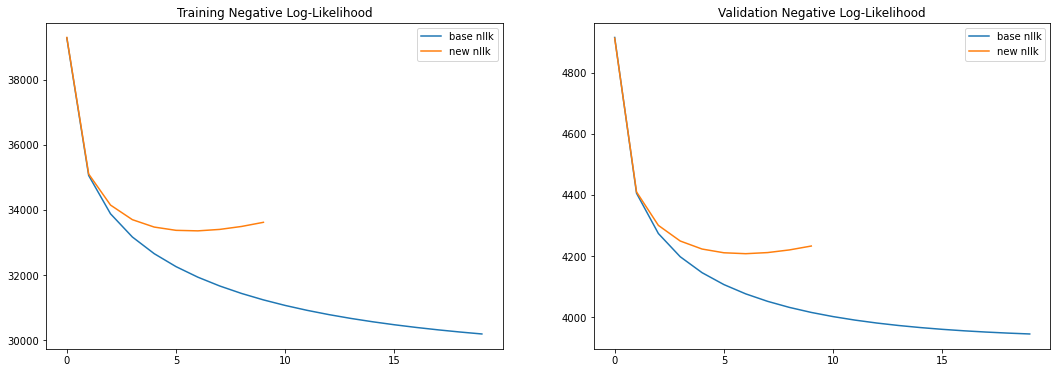

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
ax[0].plot(train_nllk_old, label="base nllk");
ax[0].plot(train_nllk, label="new nllk");
ax[0].legend();
ax[0].set_title("Training Negative Log-Likelihood");
ax[0].set_xticks(np.arange(0, 20, 5));

ax[1].plot(val_nllk_old, label="base nllk");
ax[1].plot(val_nllk, label="new nllk");
ax[1].legend();
ax[1].set_title("Validation Negative Log-Likelihood");
ax[1].set_xticks(np.arange(0, 20, 5))
fig.savefig("../figs/nllk_comparison.png")
plt.show()

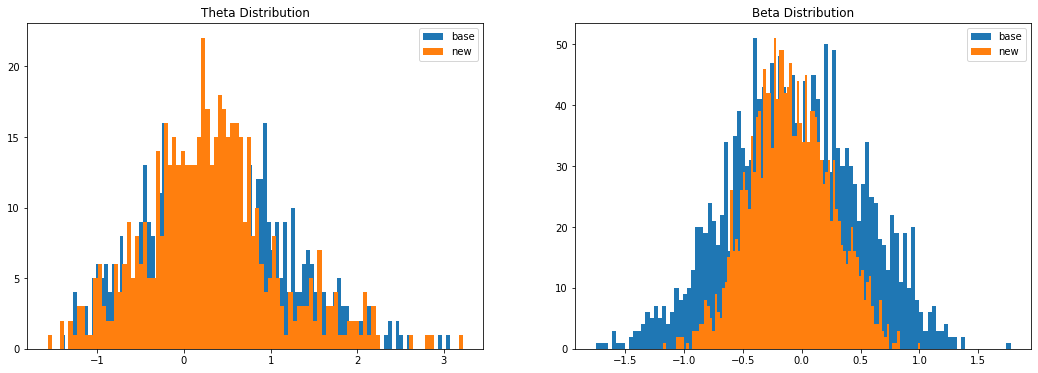

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

ax[0].hist(theta_old, label="base", bins=100);
ax[0].hist(theta, label="new", bins=100);
ax[0].legend();
ax[0].set_title("Theta Distribution");
# ax[0].set_xticks(np.arange(0, 20, 5));

ax[1].hist(beta_old, label="base", bins=100);
ax[1].hist(beta, label="new", bins=100);
ax[1].legend();
ax[1].set_title("Beta Distribution");
# ax[1].set_xticks(np.arange(0, 20, 5))
# fig.savefig("../figs/nllk_comparison.png")
plt.show()

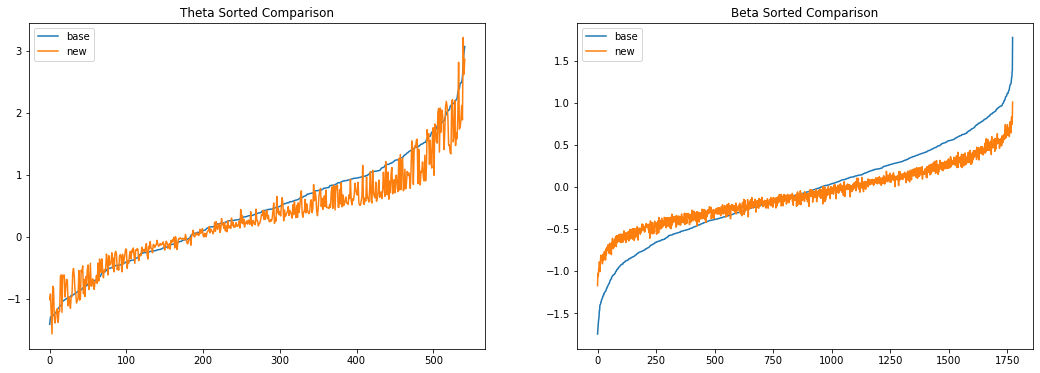

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

ax[0].plot(theta_old[np.argsort(theta_old)], label="base");
ax[0].plot(theta[np.argsort(theta_old)], label="new");
ax[0].legend();
ax[0].set_title("Theta Sorted Comparison");
# ax[0].set_xticks(np.arange(0, 20, 5));

ax[1].plot(beta_old[np.argsort(beta_old)], label="base");
ax[1].plot(beta[np.argsort(beta_old)], label="new");
ax[1].legend();
ax[1].set_title("Beta Sorted Comparison");
# ax[1].set_xticks(np.arange(0, 20, 5))
# fig.savefig("../figs/nllk_comparison.png")
plt.show()

In [511]:
# selected_questions = np.array([0])
# for selected in selected_questions:
#     plt.plot(theta, sigmoid(theta - beta[selected]), label=f"Question {selected} new");
#     plt.plot(theta_old, sigmoid(theta_old - beta_old[selected]), label=f"Question {selected} old");
#     plt.ylabel("Probability");
#     plt.xlabel("Theta");
#     plt.title("Selected Questions Probability as a function of Theta");
#     plt.legend();
# #     plt.savefig("../figs/Q2d.png");
# plt.show();

array([0.47031214, 0.44155681, 0.44279638, ..., 0.44926759, 0.42328186,
       0.45176609])

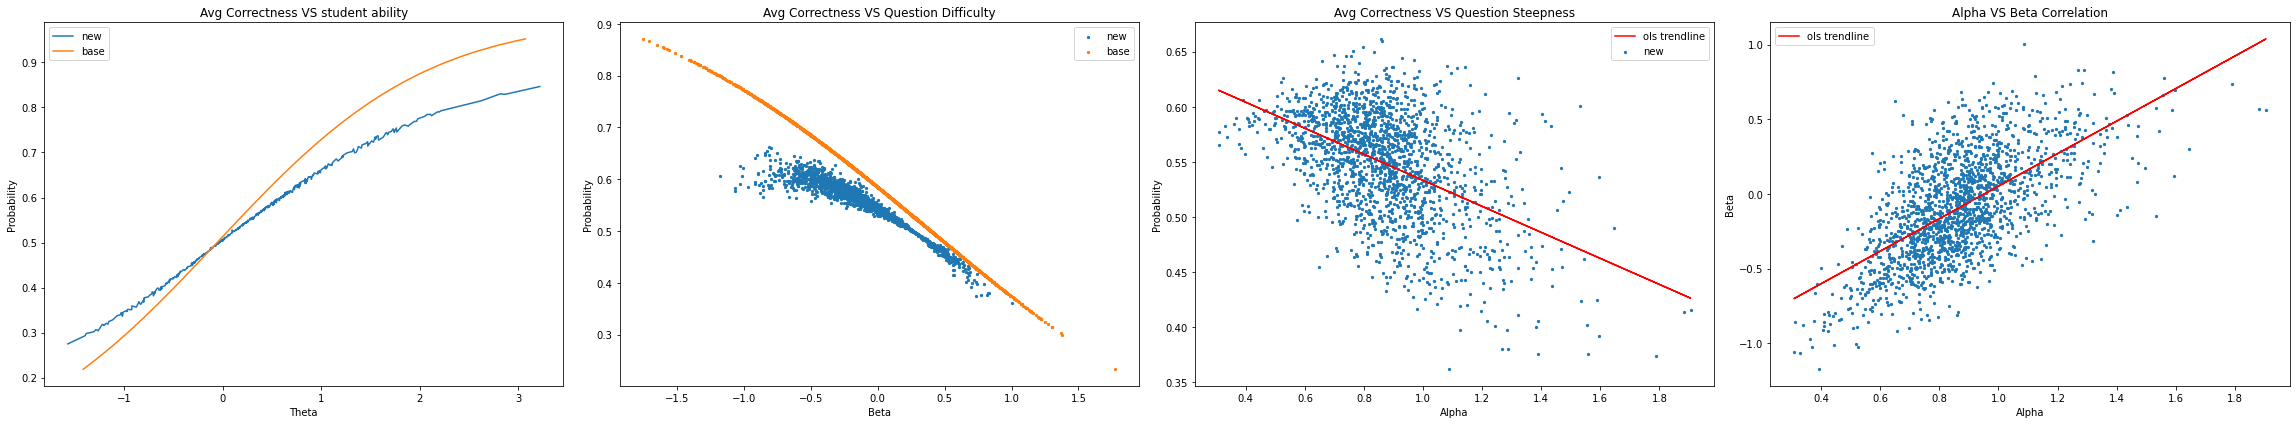

In [71]:
fig, ax = plt.subplots(ncols=4, figsize=(32, 6))

ax[0].plot(theta[np.argsort(theta)], np.mean(lower[np.argsort(theta)] + (upper[np.argsort(theta)] - lower[np.argsort(theta)]) * sigmoid(alpha * (np.repeat(theta[np.argsort(theta)].reshape(-1, 1), 1774, axis=1) - beta)).T, axis=0), label="new");
ax[0].plot(theta_old[np.argsort(theta_old)], np.mean(sigmoid(np.repeat(theta_old[np.argsort(theta_old)].reshape(-1, 1), 1774, axis=1) - beta_old), axis=1), label="base");
ax[0].legend();
ax[0].set_title("Avg Correctness VS student ability");
ax[0].set_ylabel("Probability");
ax[0].set_xlabel("Theta");


ax[1].scatter(beta, np.mean(
    lower + (upper - lower) * sigmoid(alpha * (theta - np.repeat(beta.reshape(-1, 1), 542, axis=1)).T).T,
    axis=1
), label="new", s=5);
ax[1].scatter(beta_old, np.mean(sigmoid(theta_old - np.repeat(beta_old.reshape(-1, 1), 542, axis=1)), axis=1), label="base", s=5);
ax[1].legend();
ax[1].set_title("Avg Correctness VS Question Difficulty");
ax[1].set_ylabel("Probability");
ax[1].set_xlabel("Beta");


slope, intercept = np.polyfit(alpha, np.mean(
    lower + (upper - lower) * sigmoid(alpha * (theta - np.repeat(beta.reshape(-1, 1), 542, axis=1)).T).T,
    axis=1
), 1)


ax[2].plot(alpha, alpha * slope + intercept, label="ols trendline", color="red");
ax[2].scatter(alpha, np.mean(
    lower + (upper - lower) * sigmoid(alpha * (theta - np.repeat(beta.reshape(-1, 1), 542, axis=1)).T).T,
    axis=1
), label="new", s=5);
ax[2].legend();
ax[2].set_title("Avg Correctness VS Question Steepness");
ax[2].set_ylabel("Probability");
ax[2].set_xlabel("Alpha");


slope_2, intercept_2 = np.polyfit(alpha, beta, 1)


ax[3].plot(alpha, alpha * slope_2 + intercept_2, label="ols trendline", color="red");
ax[3].scatter(alpha, beta, s=5);
ax[3].legend();
ax[3].set_title("Alpha VS Beta Correlation");
ax[3].set_ylabel("Beta");
ax[3].set_xlabel("Alpha");


plt.tight_layout()
fig.savefig("../figs/avg_correctness.png")

In [581]:
from mpl_toolkits.mplot3d import Axes3D

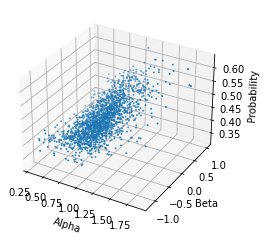

In [607]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(alpha[np.argsort(beta)], beta[np.argsort(beta)], 
            np.mean(
    lower + (upper - lower) * sigmoid(alpha[np.argsort(beta)] * (np.repeat(beta[np.argsort(beta)].reshape(-1, 1), 542, axis=1) - theta).T).T,
    axis=1
), s=1)
ax.set_xlabel("Alpha");
ax.set_ylabel("Beta");
ax.set_zlabel("Probability");

In [ ]:
Axes3D.plot(xs, ys, *args, **kwargs)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


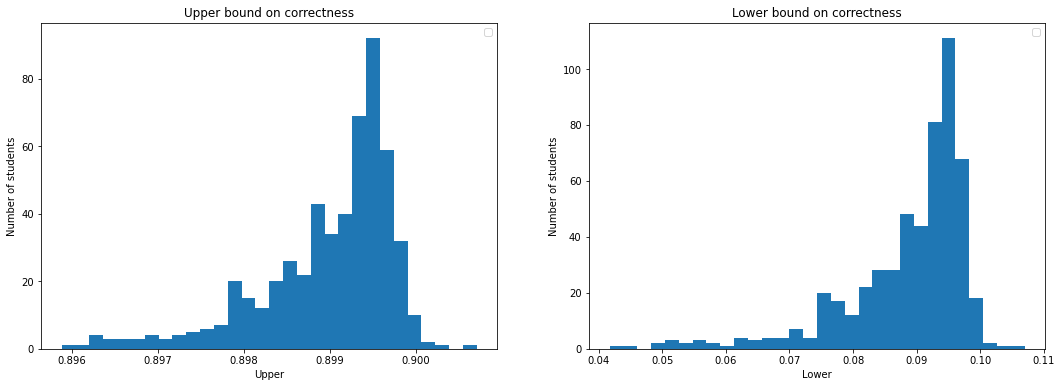

In [580]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

upper.sort()
ax[0].hist(upper, bins=30);
ax[0].legend();
ax[0].set_title("Upper bound on correctness");
ax[0].set_ylabel("Number of students");
ax[0].set_xlabel("Upper");


lower.sort()
ax[1].hist(lower, bins=30);
ax[1].legend();
ax[1].set_title("Lower bound on correctness");
ax[1].set_ylabel("Number of students");
ax[1].set_xlabel("Lower");

In [ ]:
lower[np.argsort(theta)] + (upper[np.argsort(theta)] - lower[np.argsort(theta)]) * sigmoid(alpha * (np.repeat(theta[np.argsort(theta)].reshape(-1, 1), 1774, axis=1) - beta)).T, axis=0), label="new");

In [615]:
theta[np.argsort(theta)][0:50]

array([-1.5725358 , -1.39480657, -1.38666313, -1.30954603, -1.28834671,
       -1.26685675, -1.22339078, -1.20865752, -1.20809194, -1.18199787,
       -1.16310257, -1.15558062, -1.11403913, -1.07284518, -1.0377287 ,
       -1.03068494, -1.02639005, -1.02108876, -1.0109559 , -0.98892723,
       -0.97584932, -0.97552102, -0.9727538 , -0.97233992, -0.96560313,
       -0.92437251, -0.92347128, -0.92247351, -0.87395795, -0.85508783,
       -0.85176822, -0.82567694, -0.81319643, -0.80502276, -0.79987432,
       -0.79492226, -0.78604721, -0.77357743, -0.75655718, -0.73885561,
       -0.72131073, -0.71587149, -0.70776864, -0.69737333, -0.69173555,
       -0.68832888, -0.68106738, -0.66380667, -0.65149781, -0.64667835])

In [ ]:
# Hard Question

In [809]:
1774 * 0.05

88.7

In [821]:
hard_question_ids = np.argsort(beta)[:89]
easy_question_ids = np.argsort(beta)[-89:]
hard_question_data = {"user_id":[], "question_id":[], "is_correct":[]}
easy_question_data = {"user_id":[], "question_id":[], "is_correct":[]}
for idx, question_id in enumerate(val_data["question_id"]):
    if question_id in list(hard_question_ids):
        hard_question_data["user_id"].append(val_data["user_id"][idx])
        hard_question_data["question_id"].append(val_data["question_id"][idx])
        hard_question_data["is_correct"].append(val_data["is_correct"][idx])
    if question_id in list(easy_question_ids):
        easy_question_data["user_id"].append(val_data["user_id"][idx])
        easy_question_data["question_id"].append(val_data["question_id"][idx])
        easy_question_data["is_correct"].append(val_data["is_correct"][idx])
print(evaluate(hard_question_data, theta, beta, alpha, lower, upper))
print(evaluate_2(hard_question_data, theta_old, beta_old))
print(evaluate(easy_question_data, theta, beta, alpha, lower, upper))
print(evaluate_2(easy_question_data, theta_old, beta_old))

hard_question_ids = np.argsort(beta)[:89]
easy_question_ids = np.argsort(beta)[-89:]
hard_question_data = {"user_id":[], "question_id":[], "is_correct":[]}
easy_question_data = {"user_id":[], "question_id":[], "is_correct":[]}
for idx, question_id in enumerate(test_data["question_id"]):
    if question_id in list(hard_question_ids):
        hard_question_data["user_id"].append(test_data["user_id"][idx])
        hard_question_data["question_id"].append(test_data["question_id"][idx])
        hard_question_data["is_correct"].append(test_data["is_correct"][idx])
    if question_id in list(easy_question_ids):
        easy_question_data["user_id"].append(test_data["user_id"][idx])
        easy_question_data["question_id"].append(test_data["question_id"][idx])
        easy_question_data["is_correct"].append(test_data["is_correct"][idx])
print(evaluate(hard_question_data, theta, beta, alpha, lower, upper))
print(evaluate_2(hard_question_data, theta_old, beta_old))
print(evaluate(easy_question_data, theta, beta, alpha, lower, upper))
print(evaluate_2(easy_question_data, theta_old, beta_old))

bad_student_ids = np.argsort(theta)[:27]
good_student_ids = np.argsort(theta)[-27:]
bad_student_data = {"user_id":[], "question_id":[], "is_correct":[]}
good_student_data = {"user_id":[], "question_id":[], "is_correct":[]}
for idx, user_id in enumerate(val_data["user_id"]):
    if user_id in list(bad_student_ids):
        bad_student_data["user_id"].append(user_id)
        bad_student_data["question_id"].append(val_data["question_id"][idx])
        bad_student_data["is_correct"].append(val_data["is_correct"][idx])
    if user_id in list(good_student_ids):
        good_student_data["user_id"].append(user_id)
        good_student_data["question_id"].append(val_data["question_id"][idx])
        good_student_data["is_correct"].append(val_data["is_correct"][idx])
print(evaluate(good_student_data, theta, beta, alpha, lower, upper))
print(evaluate_2(good_student_data, theta_old, beta_old))
print(evaluate(bad_student_data, theta, beta, alpha, lower, upper))
print(evaluate_2(bad_student_data, theta_old, beta_old))

bad_student_ids = np.argsort(theta)[0:27]
good_student_ids = np.argsort(theta)[-27:]
bad_student_data = {"user_id":[], "question_id":[], "is_correct":[]}
good_student_data = {"user_id":[], "question_id":[], "is_correct":[]}
for idx, user_id in enumerate(test_data["user_id"]):
    if user_id in list(bad_student_ids):
        bad_student_data["user_id"].append(user_id)
        bad_student_data["question_id"].append(test_data["question_id"][idx])
        bad_student_data["is_correct"].append(test_data["is_correct"][idx])
    if user_id in list(good_student_ids):
        good_student_data["user_id"].append(user_id)
        good_student_data["question_id"].append(test_data["question_id"][idx])
        good_student_data["is_correct"].append(test_data["is_correct"][idx])
print(evaluate(good_student_data, theta, beta, alpha, lower, upper))
print(evaluate_2(good_student_data, theta_old, beta_old))
print(evaluate(bad_student_data, theta, beta, alpha, lower, upper))
print(evaluate_2(bad_student_data, theta_old, beta_old))

0.8256130790190735
0.8092643051771117
0.7002724795640327
0.7084468664850136


0.8434343434343434
0.8232323232323232
0.6551724137931034
0.6896551724137931


0.8875968992248062
0.8875968992248062
0.7146892655367232
0.7048022598870056


0.8888888888888888
0.8888888888888888
0.6933701657458563
0.6795580110497238


In [790]:
val_data_user_id = np.array(val_data["user_id"])
val_data_question_id = np.array(val_data["question_id"])
val_data_is_correct = np.array(val_data["is_correct"])

test_data_user_id = np.array(test_data["user_id"])
test_data_question_id = np.array(test_data["question_id"])
test_data_is_correct = np.array(test_data["is_correct"])


val_acc_lst = []
test_acc_lst = []

for user_id in np.argsort(theta):
    temp_val_data = {"user_id":[], "question_id":[], "is_correct":[]}
    temp_test_data = {"user_id":[], "question_id":[], "is_correct":[]}

    temp_val_data["user_id"].extend(list(val_data_user_id[val_data_user_id == user_id]))
    temp_val_data["question_id"].extend(list(val_data_question_id[val_data_user_id == user_id]))
    temp_val_data["is_correct"].extend(list(val_data_is_correct[val_data_user_id == user_id]))
    
    temp_test_data["user_id"].extend(list(test_data_user_id[test_data_user_id == user_id]))
    temp_test_data["question_id"].extend(list(test_data_question_id[test_data_user_id == user_id]))
    temp_test_data["is_correct"].extend(list(test_data_is_correct[test_data_user_id == user_id]))
    
    val_acc_lst.append(evaluate(temp_val_data, theta, beta, alpha, lower, upper))
    test_acc_lst.append(evaluate(temp_test_data, theta, beta, alpha, lower, upper))

val_acc_lst_old = []
test_acc_lst_old = []

for user_id in np.argsort(theta_old):
    temp_val_data = {"user_id":[], "question_id":[], "is_correct":[]}
    temp_test_data = {"user_id":[], "question_id":[], "is_correct":[]}

    temp_val_data["user_id"].extend(list(val_data_user_id[val_data_user_id == user_id]))
    temp_val_data["question_id"].extend(list(val_data_question_id[val_data_user_id == user_id]))
    temp_val_data["is_correct"].extend(list(val_data_is_correct[val_data_user_id == user_id]))
    
    temp_test_data["user_id"].extend(list(test_data_user_id[test_data_user_id == user_id]))
    temp_test_data["question_id"].extend(list(test_data_question_id[test_data_user_id == user_id]))
    temp_test_data["is_correct"].extend(list(test_data_is_correct[test_data_user_id == user_id]))
    
    val_acc_lst_old.append(evaluate_2(temp_val_data, theta_old, beta_old))
    test_acc_lst_old.append(evaluate_2(temp_test_data, theta_old, beta_old))
    

D:\ProgramFiles\Anaconda\envs\csc311\lib\site-packages\ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in long_scalars
D:\ProgramFiles\Anaconda\envs\csc311\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [798]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [799]:
moving_average(test_acc_lst, 10)

array([0.61056251, 0.62669154, 0.65062317, 0.65466357, 0.67609214,
       0.67609214, 0.73109214, 0.74935301, 0.77978779, 0.79499247,
       0.84070676, 0.80070676, 0.78542898, 0.7536108 , 0.73602838,
       0.7042102 , 0.7292102 , 0.70094933, 0.65977286, 0.63755064,
       0.62242459, 0.61956744, 0.60706744,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.56312444, 0.58812444,
       0.59227078, 0.63073232, 0.65670635, 0.67670635, 0.66420635,
       0.65420635, 0.59170635, 0.61392857, 0.61392857,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.80344322,
       0.81463203, 0.7812987 ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.53200492, 0.55867158, 0.63367158,
       0.614831  , 0.614831  ,        nan,        nan,        

array([0.74493476, 0.74455811, 0.75479654, 0.73347301, 0.74381169,
       0.76015785, 0.80460229, 0.74976358, 0.73935634, 0.74117452,
       0.7206617 , 0.64923313, 0.69457875, 0.69714286, 0.66880952,
       0.66179198, 0.70464912, 0.67607769, 0.65703008, 0.69356854,
       0.71725275, 0.66582418, 0.6689011 , 0.66794872, 0.62307692,
       0.60450549, 0.58450549, 0.66142857,        nan,        nan,
              nan,        nan,        nan, 0.69189807, 0.73189807,
       0.67676987, 0.68219973, 0.65763833, 0.62282051, 0.61282051,
       0.70948718, 0.65307692, 0.66974359, 0.68860215, 0.63860215,
       0.55860215, 0.69193548, 0.64193548, 0.66      , 0.69333333,
       0.74070175, 0.59070175, 0.62403509, 0.46403509, 0.44608637,
       0.44871795, 0.53811189, 0.58477855, 0.70977855, 0.59439394,
       0.57296537, 0.55857143, 0.47857143, 0.42725564, 0.59868421,
       0.61479363, 0.68979363, 0.73265078, 0.74896657, 0.66325228,
       0.64164835, 0.44164835, 0.44879121, 0.53656899, 0.55085

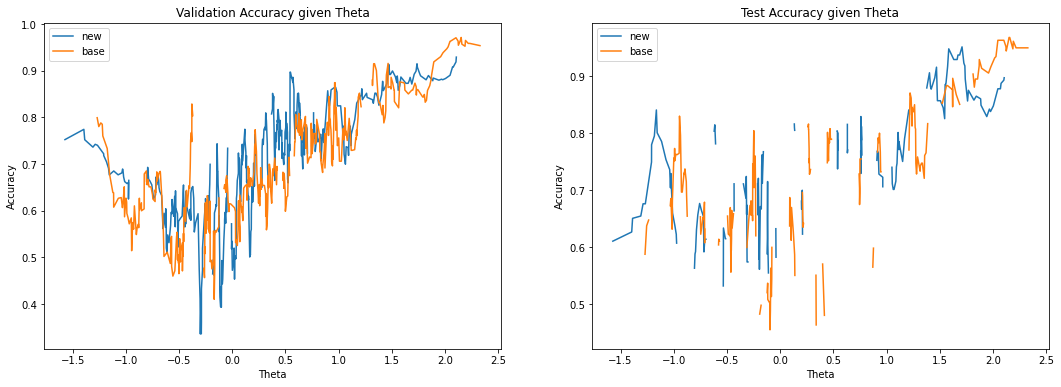

In [808]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

ax[0].plot(theta[np.argsort(theta)][:-9], moving_average(val_acc_lst, 10), label="new");
ax[0].plot(theta_old[np.argsort(theta_old)][:-9], moving_average(val_acc_lst_old, 10), label="base");
ax[0].legend();
ax[0].set_title("Validation Accuracy given Theta");
ax[0].set_ylabel("Accuracy");
ax[0].set_xlabel("Theta");

ax[1].plot(theta[np.argsort(theta)][:-9], moving_average(test_acc_lst, 10), label="new");
ax[1].plot(theta_old[np.argsort(theta_old)][:-9], moving_average(test_acc_lst_old, 10), label="base");
ax[1].legend();
ax[1].set_title("Test Accuracy given Theta");
ax[1].set_ylabel("Accuracy");
ax[1].set_xlabel("Theta");


In [797]:
test_acc_lst_old

[1.0,
 1.0,
 0.2,
 0.8387096774193549,
 nan,
 0.5,
 0.5,
 0.5384615384615384,
 0.7272727272727273,
 0.4,
 1.0,
 0.7777777777777778,
 0.6956521739130435,
 0.7368421052631579,
 0.0,
 1.0,
 0.6,
 nan,
 0.5,
 1.0,
 0.5,
 0.25,
 1.0,
 0.5,
 0.8181818181818182,
 0.6,
 0.7272727272727273,
 0.8333333333333334,
 0.625,
 0.46153846153846156,
 1.0,
 1.0,
 1.0,
 0.6666666666666666,
 0.6,
 0.7142857142857143,
 0.7222222222222222,
 0.8571428571428571,
 1.0,
 0.7391304347826086,
 0.6666666666666666,
 0.0,
 1.0,
 1.0,
 0.5882352941176471,
 0.8,
 0.5,
 0.625,
 0.625,
 nan,
 nan,
 0.7058823529411765,
 0.45454545454545453,
 1.0,
 0.6923076923076923,
 0.7073170731707317,
 0.7142857142857143,
 0.4,
 0.5714285714285714,
 0.6,
 0.6875,
 0.4,
 0.75,
 1.0,
 0.6666666666666666,
 1.0,
 0.0,
 0.6428571428571429,
 nan,
 0.4,
 0.7,
 0.9090909090909091,
 0.7142857142857143,
 0.6666666666666666,
 0.0,
 0.7142857142857143,
 0.7692307692307693,
 0.6666666666666666,
 0.5,
 0.5,
 0.6666666666666666,
 nan,
 0.818181818181